# Notebook III - Merging Data & EDA

In [94]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# graphing
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# read trips data
trips = pd.read_csv('./cleaned_data/trips_cleaned_aggregated.csv')

# read weather data
weather = pd.read_csv('./cleaned_data/weather_cleaned.csv')

---
#### NOTE: 
The original goal of this notebook was to merge cleaned trips and weather data to create a full dataset that I would use to compare/contrast the effects of several metrics on trip data (duration, revenue, count). However, upon fixing the trips dataset in Notebook I after the epiphany I had (section 1e), I realize that there are **many more caveats** that need to be addressed prior to conducting any EDA and examining relationships between proposed independent variables and the intended outcome variable, daily revenue. <br><br>

For example, below I read in the cleaned dataset with aggregated trip data. The data is set up to have daily rows (730) from 2014-2015 for every station and aggregated trip information (0 if no trips were taken). The issue is that, as it stands, there is no way to confirm whether the station just had no demand for consecutive "0-count" days, or if the station had simply not been active at that time. Please refer to the below preview of "6th and Navasota St.":

---

In [118]:
trips[(trips['start_station_id'] == 1002) & (trips['duration_minutes'] > 0)]

,date,start_station_id,start_station_name,month,day,year,duration_minutes,trip_revenue,trip_count,day_of_week
28,2014-01-29,1002,6th & Navasota St.,1,29,2014,14.0,2.4,1.0,Wednesday
29,2014-01-30,1002,6th & Navasota St.,1,30,2014,41.0,7.1,3.0,Thursday
30,2014-01-31,1002,6th & Navasota St.,1,31,2014,49.0,8.9,4.0,Friday
31,2014-02-01,1002,6th & Navasota St.,2,1,2014,1271.0,141.1,14.0,Saturday
34,2014-02-04,1002,6th & Navasota St.,2,4,2014,209.0,21.9,1.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...
176,2014-06-26,1002,6th & Navasota St.,6,26,2014,5.0,1.5,1.0,Thursday
177,2014-06-27,1002,6th & Navasota St.,6,27,2014,124.0,21.4,9.0,Friday
178,2014-06-28,1002,6th & Navasota St.,6,28,2014,520.0,59.0,7.0,Saturday
179,2014-06-29,1002,6th & Navasota St.,6,29,2014,679.0,70.9,3.0,Sunday


Here, I have filtered on all non-0 data for this station. This means that this station had no rides until January 29th, 2014, and basically ceased getting rides after June 30th, 2014. On all other days in the 2-year time frame, there were no trips taken from "6th & Navasota". It is highly unlikely that the station remained that unpopular for all other days. What is more likely is that the bike company either installed it at a certain time, or removed it at another time. This same assumption can be stretched to all 60 stations in our dataset. We simply do not know what is causing gaps, however, longer gaps we can assume are caused by deactivation of the station and not a decline in demand. A gap or a day or two is more reasonable, however. <br><br>

That being said, for a lot of the data where stations had no rides for long stretches, there is still daily weather data that I merged below. When conducting EDA to extract relationships between these independent variables and the outcome, revenue, we cannot draw any meaningful conclusions since this data is associated with other factors not being picked up by our dataset. It's not necessary that some kind of weather metric affected the \$0 revenue that 6th & Navasota had on 1/1/2014. It simply could just not have been an active station at that point and was installed by the company later on. <br><br>

I would love to discuss this further on how to better capture such relationships with panel data. My current thought process would be to filter on some station individually, effectively reducing the dataset to a time-series and filtering further on dates when the station became active. I will attempt to do so in place of my initial EDA analysis below. However, for modeling purposes for now, I will forego adding other metrics until I am more comfortable on how to obtain meaningful insights without the confounding any associations as I outlined above.

In [119]:
##### TO DO - Future action list: ##### 

### filter on 1-2 different stations (in predictions) separately and conduct brief EDA there --> see if correlations differ

### try to filter the dates on when we think the data might begin 

### provide suggestions on how to do this uniformly for other stations

---
### 3a. Merge Weather Data with Trips

In [95]:
trips.head()

,date,start_station_id,start_station_name,month,day,year,duration_minutes,trip_revenue,trip_count,day_of_week
0,2014-01-01,1002,6th & Navasota St.,1,1,2014,0.0,0.0,0.0,Wednesday
1,2014-01-02,1002,6th & Navasota St.,1,2,2014,0.0,0.0,0.0,Thursday
2,2014-01-03,1002,6th & Navasota St.,1,3,2014,0.0,0.0,0.0,Friday
3,2014-01-04,1002,6th & Navasota St.,1,4,2014,0.0,0.0,0.0,Saturday
4,2014-01-05,1002,6th & Navasota St.,1,5,2014,0.0,0.0,0.0,Sunday


In [97]:
weather.head()

,date,temphigh_f,tempavg_f,templow_f,humidityhigh_percent,humidityavg_percent,humiditylow_percent,visibilityhigh_miles,visibilityavg_miles,visibilitylow_miles,windhigh_mph,windavg_mph,windgust_mph,precipitation_inches,fog,rain,snow,thunderstorm
0,2014-01-01,69.0,54.0,39.0,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
1,2014-01-02,55.0,44.0,33.0,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.0,0,0,0,0
2,2014-01-03,58.0,43.0,28.0,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.0,0,0,0,0
3,2014-01-04,71.0,57.0,42.0,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.0,0,0,0,0
4,2014-01-05,59.0,47.0,34.0,87.0,59.0,31.0,10.0,10.0,4.0,21.0,10.0,34.0,0.0,0,0,0,0


In [98]:
print(trips.shape, weather.shape)

(43800, 10) (1096, 18)


In [99]:
# merge
    # how = 'right' --> this will ensure data for 2016 is pulled from weather
merged_data = pd.merge(trips, weather, on = 'date', how = 'right')
merged_data

,date,start_station_id,start_station_name,month,day,year,duration_minutes,trip_revenue,trip_count,day_of_week,...,visibilityavg_miles,visibilitylow_miles,windhigh_mph,windavg_mph,windgust_mph,precipitation_inches,fog,rain,snow,thunderstorm
0,2014-01-01,1002.0,6th & Navasota St.,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
1,2014-01-01,1003.0,8th & Guadalupe,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
2,2014-01-01,1005.0,State Parking Garage @ Brazos & 18th,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
3,2014-01-01,1006.0,Zilker Park West,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
4,2014-01-01,1007.0,Lavaca & 6th,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44161,2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,7.0,1.0,11.0,0.0,0,0,0,0
44162,2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,4.0,12.0,3.0,20.0,0.0,0,0,0,0
44163,2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,18.0,9.0,30.0,0.0,0,0,0,0
44164,2016-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,12.0,4.0,16.0,0.0,0,0,0,0


In [106]:
# move date column to the beginning
date_col = merged_data.pop('date')
merged_data.insert(0, 'date', date_col)

In [107]:
# fixing column data types again
merged_data[['start_station_id','month','day','year']] = merged_data[['start_station_id','month','day','year']].astype(object) 

# the 'type' will be changed to object, but cannot convert to int first to rid of the decimal (NaNs present for 2016 data)

---
### 3b. EDA on Numeric Features

The goal of this section is to determine which numeric variables are most closely associated with our intended outcome, `trip_revenue`. Creating a correlation matrix to check the correlation between the independent variables will also give us a better idea of which variables are strongly correlated with one another. This will allow us to drop features and keep the ones we feel can best assist in forecasting `trip_revenue`.

In [108]:
# identifying numeric columns
numeric_cols = [var for var in merged_data.columns if merged_data[var].dtype != 'O']
numeric_cols

['duration_minutes',
 'trip_revenue',
 'trip_count',
 'temphigh_f',
 'tempavg_f',
 'templow_f',
 'humidityhigh_percent',
 'humidityavg_percent',
 'humiditylow_percent',
 'visibilityhigh_miles',
 'visibilityavg_miles',
 'visibilitylow_miles',
 'windhigh_mph',
 'windavg_mph',
 'windgust_mph',
 'precipitation_inches',
 'fog',
 'rain',
 'snow',
 'thunderstorm']

In [109]:
# corr matrix
corr_on_trips = merged_data[numeric_cols].corr()[['duration_minutes', 'trip_revenue', 'trip_count']]

# making a mask for matrix
mask = np.triu(np.ones_like(corr_on_trips, dtype = bool))

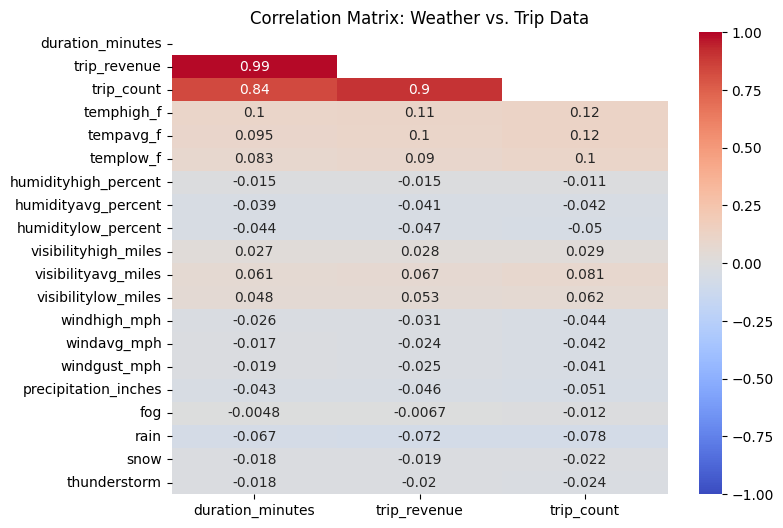

In [110]:
# plotting corr matrix
plt.figure(figsize = (8,6))
sns.heatmap(corr_on_trips, mask = mask, cmap = 'coolwarm', annot = True, vmin = -1, vmax = 1)
plt.title('Correlation Matrix: Weather vs. Trip Data');

plt.savefig('./graphs/correlation_matrix.jpeg', dpi = 1080)

#### ***Disclaimer***
To reiterate, the correlations here cannot be relied upon nor provide us with an accurate sense of the relationship between these variables. I have outlined this in the opening section of this notebook. <br><br>

#### Future To Do: 
- Redo correlation matrix, and filter only on one station
- Figure out way to conduct this analysis for all stations
- Need to factor in different start dates for stations (some stations do not have any data for several months)

---
### 3c. EDA on Categorical Features

#### ***Disclaimer***
The EDA here is also affected by the fix in the dataset. There are many days with no trips, but some of these values should not affect averages if the stations simply didn't exist at the time. I will leave the conducted EDA to inspire ideas on how to examine the data in the future. Again, looking at the data after filtering on a specific station may prove insightful and allow comparison between two stations. <br>

#### Other EDA Ideas I'd Like to Do:
1. Rush hour times? - Examining rides by hour of day (requires bucketing of the `start_time` variable in raw trips data
2. Downtown vs. College vs. Recreational - Comparing trip metrics by assigning and evaluating station type

In [111]:
merged_data

,date,start_station_id,start_station_name,month,day,year,duration_minutes,trip_revenue,trip_count,day_of_week,...,visibilityavg_miles,visibilitylow_miles,windhigh_mph,windavg_mph,windgust_mph,precipitation_inches,fog,rain,snow,thunderstorm
0,2014-01-01,1002.0,6th & Navasota St.,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
1,2014-01-01,1003.0,8th & Guadalupe,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
2,2014-01-01,1005.0,State Parking Garage @ Brazos & 18th,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
3,2014-01-01,1006.0,Zilker Park West,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
4,2014-01-01,1007.0,Lavaca & 6th,1.0,1.0,2014.0,0.0,0.0,0.0,Wednesday,...,10.0,8.0,13.0,4.0,22.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44161,2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,7.0,1.0,11.0,0.0,0,0,0,0
44162,2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,4.0,12.0,3.0,20.0,0.0,0,0,0,0
44163,2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,18.0,9.0,30.0,0.0,0,0,0,0
44164,2016-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,12.0,4.0,16.0,0.0,0,0,0,0


#### Day of the Week vs. Avg. Revenue

In [112]:
day_of_week_revenue = merged_data.groupby('day_of_week')['trip_revenue'].mean().reset_index()
day_of_week_revenue

,day_of_week,trip_revenue
0,Friday,30.036538
1,Monday,19.709119
2,Saturday,49.521987
3,Sunday,37.938942
4,Thursday,19.359968
5,Tuesday,16.888526
6,Wednesday,16.882778


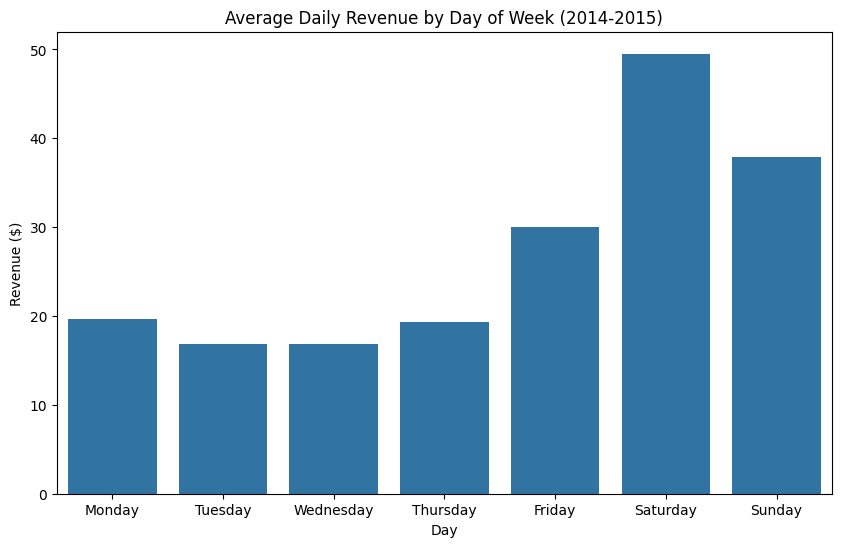

In [113]:
# graphing
plt.figure(figsize = (10, 6))
sns.barplot(x = 'day_of_week', y = 'trip_revenue', data = day_of_week_revenue, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                                                       'Friday', 'Saturday', 'Sunday'])
plt.title('Average Daily Revenue by Day of Week (2014-2015)')
plt.xlabel('Day')
plt.ylabel('Revenue ($)');

plt.savefig('./graphs/day_vs_revenue.jpeg', dpi = 1080)

Visually, we can see that there may be a trend present. This might suggest that the data is cyclical by week as it seems to peak in the weekends, and drop during mid-week. This gives an interesting clue about seasonality prior to modeling. <br><br>

***FOR FUTURE:***
I have not yet gotten to this, but I would like to conduct an ANOVA test here to check to see if the differences in average revenue for the days are statistically significant.

#### Month vs. Avg Revenue

In [114]:
month_revenue = merged_data.groupby('month')['trip_revenue'].mean().reset_index()
month_revenue

,month,trip_revenue
0,1.0,10.736425
1,2.0,16.458631
2,3.0,50.881129
3,4.0,33.317361
4,5.0,32.601129
5,6.0,28.031889
6,7.0,28.366344
7,8.0,22.498118
8,9.0,24.080750
9,10.0,41.177742


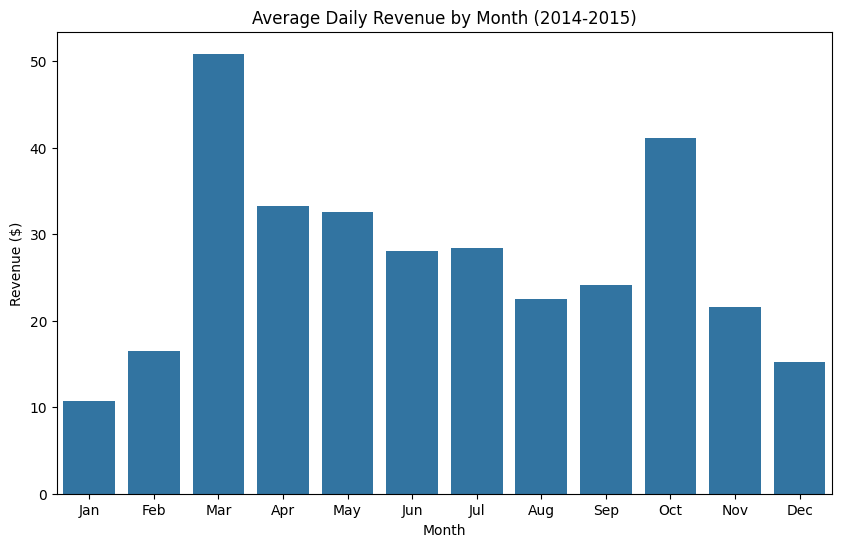

In [115]:
# graphing
plt.figure(figsize = (10, 6))
sns.barplot(x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                'Nov', 'Dec'], y = 'trip_revenue', data = month_revenue)
plt.title('Average Daily Revenue by Month (2014-2015)')
plt.xlabel('Month')
plt.ylabel('Revenue ($)');

plt.savefig('./graphs/month_vs_revenue.jpeg', dpi = 1080)

In [116]:
# saving the merged data
merged_data.to_csv('./cleaned_data/trips_weather_merged.csv', index = False)